In [1]:
#tools
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
from pandas import DataFrame
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import pickle
from acfunctions import *
import eleanor
from IPython.display import Image
import lightkurve as lk
from starspot import sigma_clipping
import starspot as ss
from lightkurve import search_targetpixelfile
from IPython.display import display, HTML
import starspot.rotation_tools as rt
from scipy import interpolate
import exoplanet
import eleanor
from bokeh.models import ColumnDataSource, LabelSet, Whisker
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.sampledata.autompg import autompg as df

import warnings
warnings.filterwarnings("ignore")

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
def find_m_b(x,y,err): #analytical approach to finding line of best fit 
    #C     
    errorsq = np.square(err)
    C = np.diag(errorsq)

    #A 
    xb = ([1] * len(x))
    mata = []
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
    A= np.matrix(mata).reshape((len(x), 2))

    #plugging in 
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)

    m = float(cov[0])
    b = float(cov[1])
    return m ,b 

def residuals(x, y, error): #residual abundance function
    mborig = find_m_b(x, y, error)
    m = mborig[0]
    b = mborig[1]

    predicted_values = [] #y values from slope
    pv = 0
    for u in x:
        pv = (m*u) + b
        predicted_values.append(pv)
        pv = 0

    prev = np.array(predicted_values)
    abu = np.array(y)
    diff = abu - prev #difference between slope and measured values  
    return diff

In [5]:
#dataset with tess vs kepler IDs
tess_kep = pd.read_csv('data_summary.csv')
tess_short = tess_kep[tess_kep.tess_ffi == True]
cat = pd.read_csv('tics_kics_mcq_rot.txt', names=['tic_id', 'kic_id', 'prot'], delim_whitespace=True)

In [6]:
#importing McQ periods
headers = 'TIC ID', 'KIC ID', 'McQ Periods';  

with open("tics_kics_mcq_rot.txt") as file:
    rot_table = [line.split() for line in file.read().splitlines()]

widths = [max(len(value) for value in col)
for col in zip(*(rot_table + [headers]))]

formatting = '{:{widths[0]}}  {:{widths[1]}}  {:{widths[2]}}'
formatting.format(*headers, widths=widths)
for tics_kics_mcq in rot_table:
    formatting.format(*tics_kics_mcq, widths=widths)

In [7]:
# converting txt file data to arrays
tic_ids = []
mcq_periods = []

for index, row in enumerate(rot_table):
    tic_ids.append(int(rot_table[index][0]))
    mcq_periods.append(float(rot_table[index][2]))

In [8]:
# selecting shortest periods only (<13 days, half a tess cycle)
short_periods = []
tics_short_periods = []

for index, period in enumerate(mcq_periods):
    if period < 13: 
        short_periods.append(period)
        tics_short_periods.append(tic_ids[index])

In [9]:
tic_super_short = []
for each, per in enumerate(mcq_periods):
    if per < 6: 
        tic_super_short.append(tic_ids[each])

In [10]:
tess_2m, tess_30m, two_m, thirty_m, errors = [], [], [], [], []

In [11]:
tic_super_short

[171098535,
 63209318,
 271426791,
 272719990,
 351055098,
 137408312,
 27389081,
 360022896,
 184090759,
 272596433,
 271538204,
 159721038,
 63291536,
 271959015,
 270705471,
 271882234,
 171097828,
 299218911,
 164652676,
 272598447,
 159761678,
 268606389,
 424865046,
 159717504,
 121276464,
 270696609,
 268380764,
 63070333,
 120693506,
 159717535,
 273685880,
 27187836,
 120963587,
 268160328,
 271424552,
 164670612,
 138638653,
 159717530,
 270860449,
 270619467,
 169458210,
 273690159,
 159105715,
 378083841,
 27531488,
 164413746,
 137402084,
 120684614,
 273374778,
 274031107,
 121393797,
 27695477,
 352012006,
 272943796,
 351191410,
 267745242,
 120893534,
 416528984,
 164670606,
 417676649,
 159301242,
 27773745,
 399867682,
 123201168,
 273372356,
 123310578,
 169815697,
 121941187,
 159717485,
 272720008,
 121327452,
 270696968,
 27843903,
 158317151,
 26749607,
 184555203,
 27014610,
 159650667,
 164778770,
 299218388,
 123230837,
 158420853,
 26656591,
 299154648,
 394

for each, val in tqdm(enumerate(tics_short_periods)): 
    star = lk.search_targetpixelfile('TIC' + str(val), mission = 'TESS')
    
    if len(star) > 0: #checking for star in 2min cadence tess databse
        print(star)
        tess_2m.append(val)
        two_m.append(star)

for each, val in tqdm(enumerate(tic_super_short[83:])): 
    star = lk.search_targetpixelfile('TIC' + str(val), mission = 'TESS')
    
    if len(star) > 0: #checking for star in 2min cadence tess databse
        print(star)
        tess_2m.append(val)
        two_m.append(star)

for ind, each in enumerate(tics_short_periods[0:61]):
    value = 'TIC' + str(each)
    star_thirty = eleanor.Source(name = value) #checking for star in 30min database
    print(star_thirty)
    tess_30m.append(value)
    thirty_m.append(star_thirty)

tess_30m

with open('tess_2m.data', 'wb') as filehandle:
    pickle.dump(tess_2m, filehandle)
    
#with open('tess_30m.data', 'wb') as filehandle:
    #pickle.dump(tess_30m, filehandle)

In [12]:
with open('tess_2m.data', 'rb') as filehandle:
    tess_2m = pickle.load(filehandle) #list of two min cadence target names and sectors
    
#with open('tess_30m.data', 'rb') as filehandle:
    #tess_30m = pickle.load(filehandle) #list of thirty min cadence target names and sectors

In [13]:
tess_2m

[63209318,
 272596433,
 159721038,
 271959015,
 164652676,
 272598447,
 424865046,
 270696609,
 120693506,
 120963587,
 270619467,
 164413746,
 273374778,
 267745242,
 164670606,
 27773745,
 399867682,
 123201168,
 121327452,
 270696968,
 27843903,
 158317151,
 164778770,
 123230837,
 121456902,
 121123220,
 298787492,
 377782358,
 122447460,
 27911635,
 351910775,
 120765034,
 27006972,
 271355239,
 272272592,
 270705470,
 122300184,
 123414877]

ls_thirty = []
pdm_thirty = []
exo_thirty = []

for each, tic in enumerate(tess_30m): 
    star = eleanor.Source(tic=tic[3:])
    data = eleanor.TargetData(star, do_psf=True, do_pca=True)
    
    q = data.quality == 0
    time = data.time[q] 
    flux_nan = (data.pca_flux[q])[~np.isnan(data.pca_flux[q])]
    norm_flux = flux_nan/np.nanmedian(data.pca_flux[q])
   
    try: 
    #original 
        norm_flux_err = np.sqrt(norm_flux)
        resid = residuals(time, norm_flux, norm_flux_err)
        resid = resid[~np.isnan(resid)]
        time = time[~np.isnan(resid)]   
        
        f = interpolate.interp1d(time, resid)
        xnew = np.arange(time[0], time[-1], 0.1)
        flux = f(xnew) 
        flux_err = np.sqrt(flux)

        #cropping out section
        mask = (time <= 1695) & (time >= 1690)
        norm_flux_2 = norm_flux[~mask]
        time_masked = time[~mask]
    
        mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
        norm_flux_mask = norm_flux_2[~mask_2]
        time_mask = time_masked[~mask_2]

        #removing trends 
        norm_flux_err_mask = np.sqrt(norm_flux_mask)
        resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
        resid_mask = resid_mask[~np.isnan(resid_mask)]
        time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
        f = interpolate.interp1d(time_mask, resid_mask)
        xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
        flux_mask = f(xnew_mask) 
        flux_err_mask = np.sqrt(flux_mask)
    
        fig, axs = plt.subplots()
        fig.tight_layout(h_pad=6)
        plt.figure(figsize=(15,5))
        plt.plot(xnew, flux, 'royalblue')
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1690) & (xnew <= 1695), 
                 color = 'aliceblue') 
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1704) & (xnew <= 1709), 
                 color = 'aliceblue')

        plt.plot(xnew_mask, flux_mask, 'k')
        fig.savefig('tess_{0}_2m.jpg'.format(each))
        plt.close(fig)

        #exo acf
        ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
        exo_period = ex_1['peaks'][0]['period']
        exo_thirty.append(exo_period)

        
        #lomb-scargle 
        rotate_el = ss.RotationModel(xnew_mask, flux_mask, flux_err_mask)
        ls_period = rotate_el.ls_rotation()
        ls_thirty.append(ls_period)
       
        #pdm 
        period_grid = np.linspace(.1, 10, 1000)
        pdm_period, period_err = rotate_el.pdm_rotation(period_grid, pdm_nbins=10)    
        pdm_thirty.append(pdm_period)
        print('works!')
    
        
    except : 
        print('error')
        ls_thirty.append(0)
        pdm_thirty.append(0)
        exo_thirty.append(0)

with open('ls_thirty.data', 'wb') as filehandle:
    pickle.dump(ls_thirty, filehandle)
    
with open('pdm_thirty.data', 'wb') as filehandle:
    pickle.dump(pdm_thirty, filehandle)
    
with open('exo_thirty.data', 'wb') as filehandle:
    pickle.dump(exo_thirty, filehandle)  

100%|██████████| 1000/1000 [00:00<00:00, 1942.76it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1727.29it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1473.85it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1653.87it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1595.60it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1597.91it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1450.25it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1613.66it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1584.05it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1527.24it/s]


works!


100%|██████████| 1000/1000 [00:02<00:00, 452.47it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1629.92it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1056.43it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1520.79it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1716.80it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1072.61it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1973.54it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1863.27it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1619.15it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1721.03it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1591.08it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1833.64it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 802.90it/s]


works!


100%|██████████| 1000/1000 [00:01<00:00, 817.93it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1760.50it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1803.67it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1258.29it/s]


works!


100%|██████████| 1000/1000 [00:00<00:00, 1858.27it/s]


fitting to a limited range
works!


100%|██████████| 1000/1000 [00:00<00:00, 1721.32it/s]


works!


KeyboardInterrupt: 

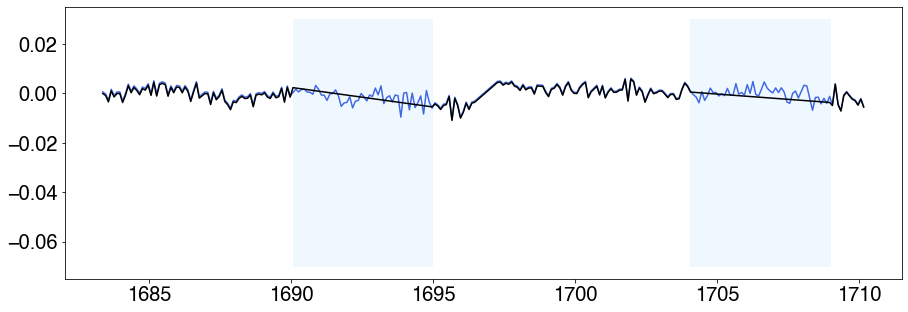

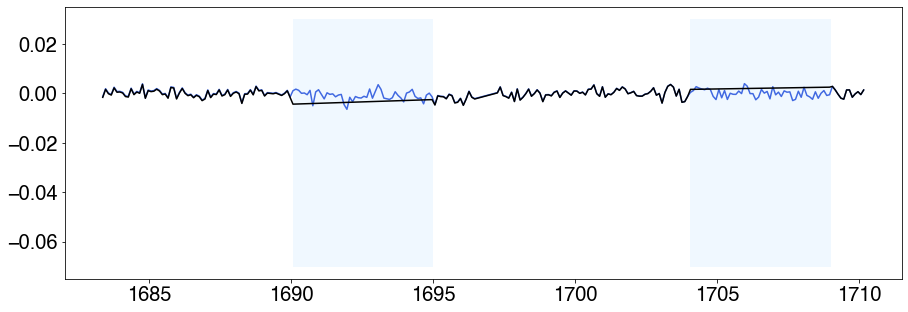

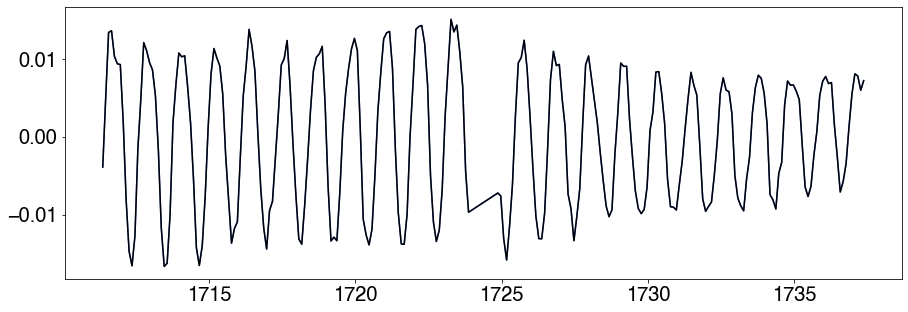

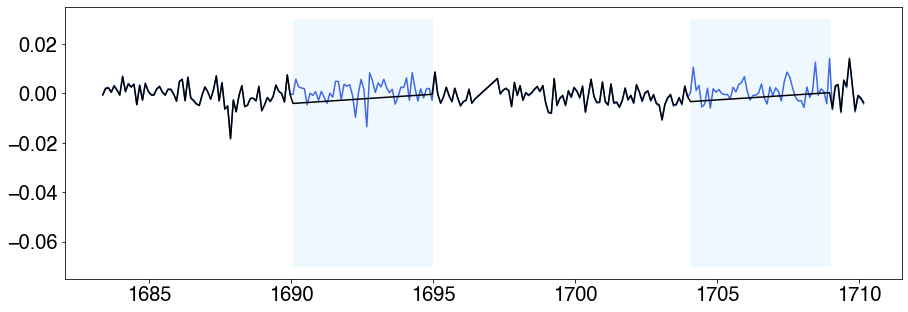

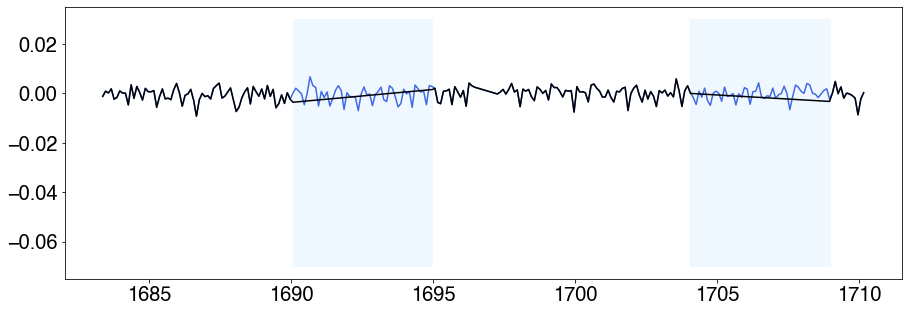

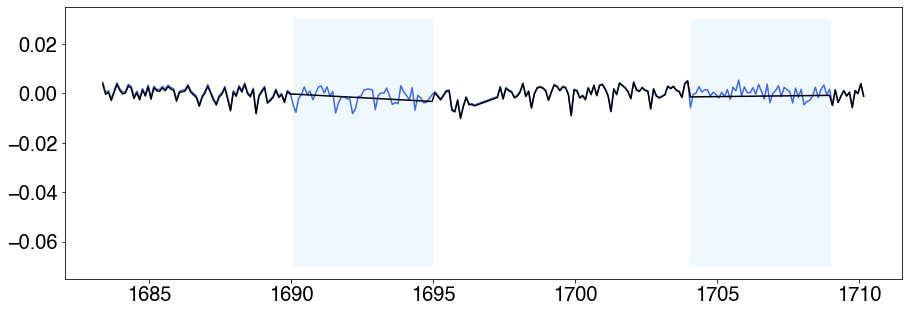

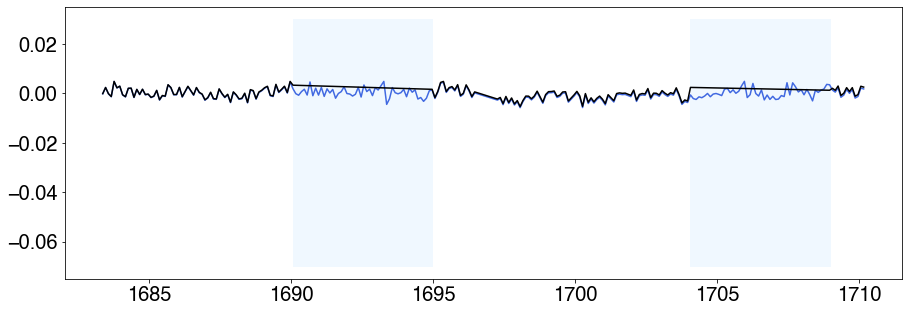

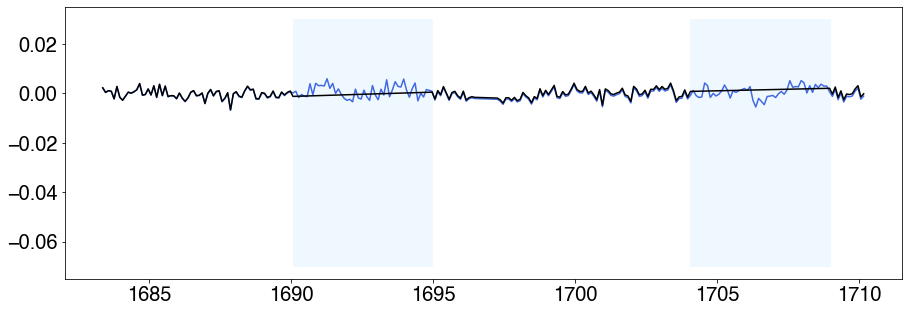

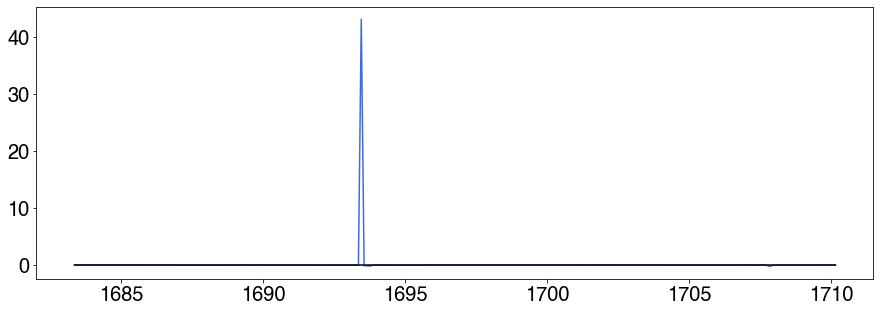

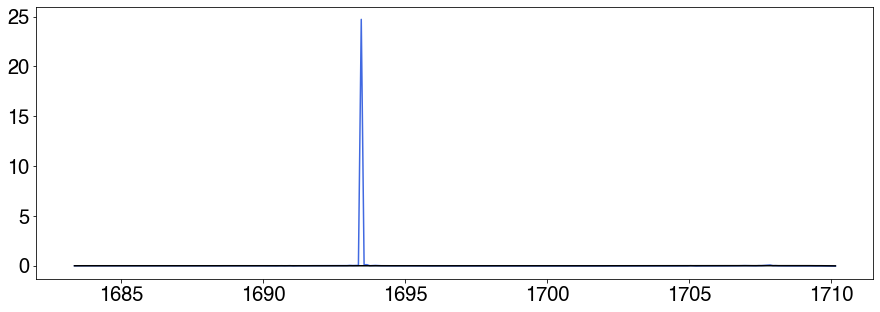

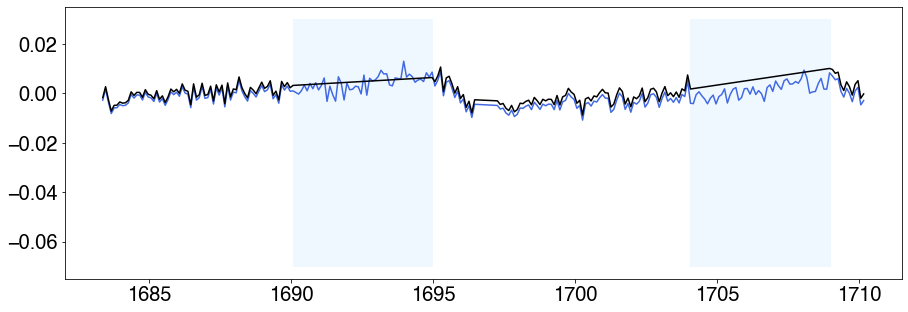

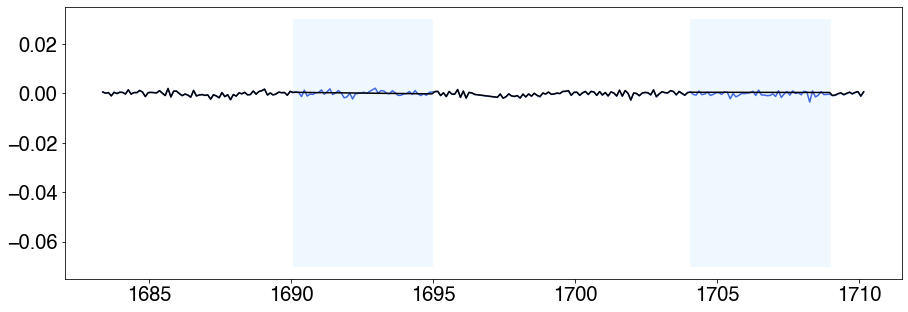

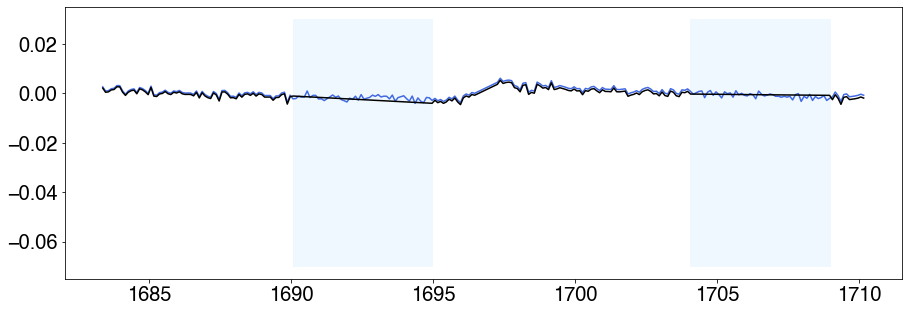

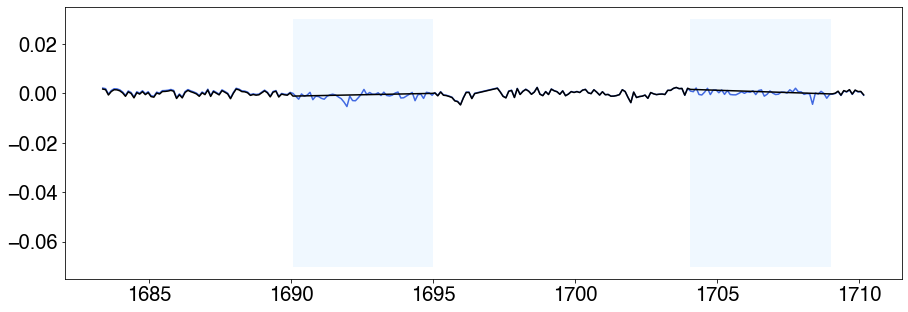

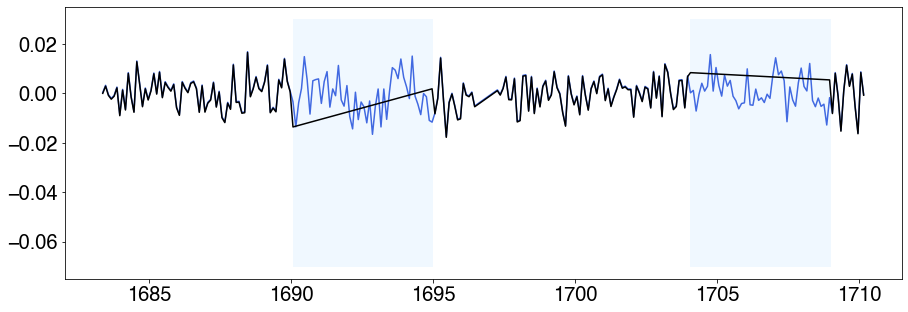

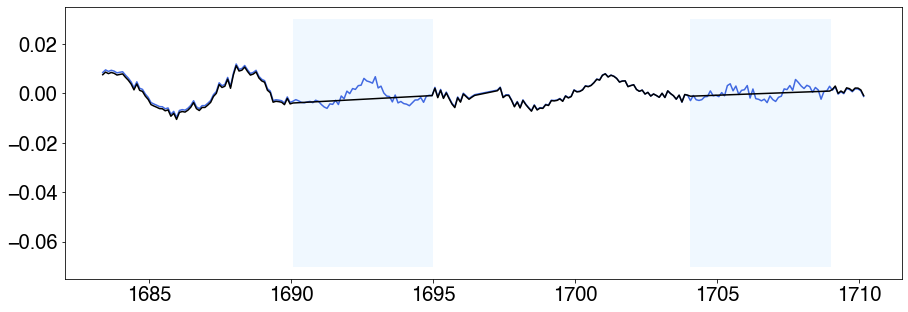

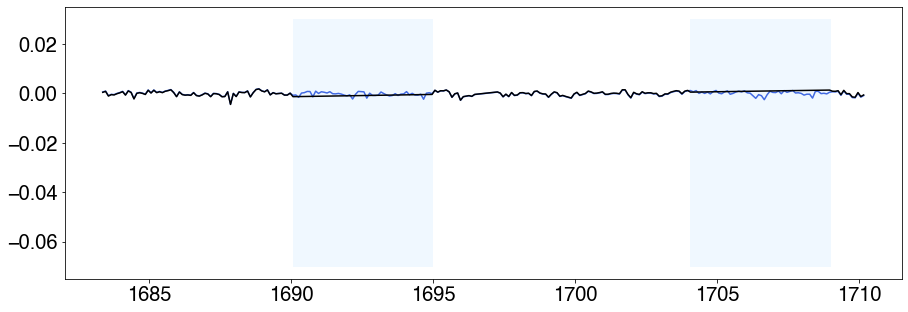

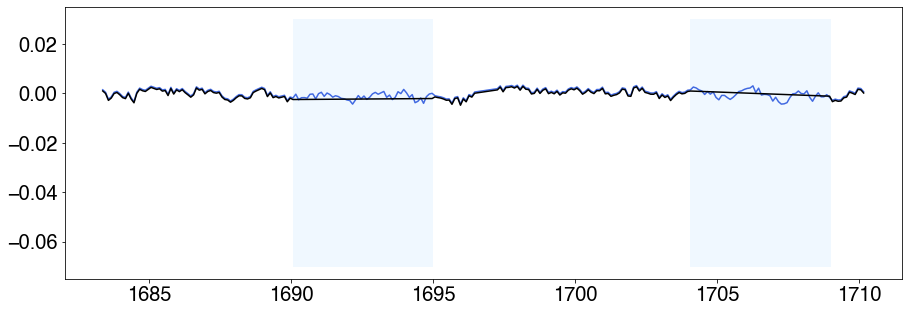

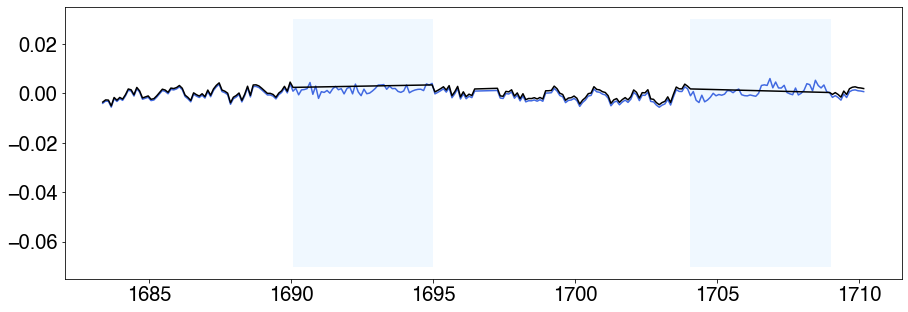

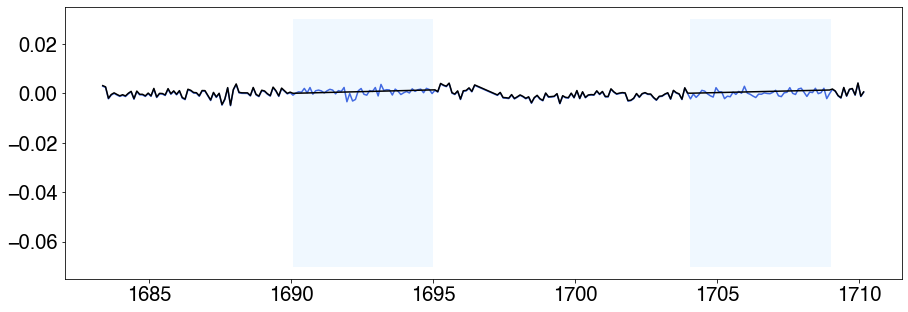

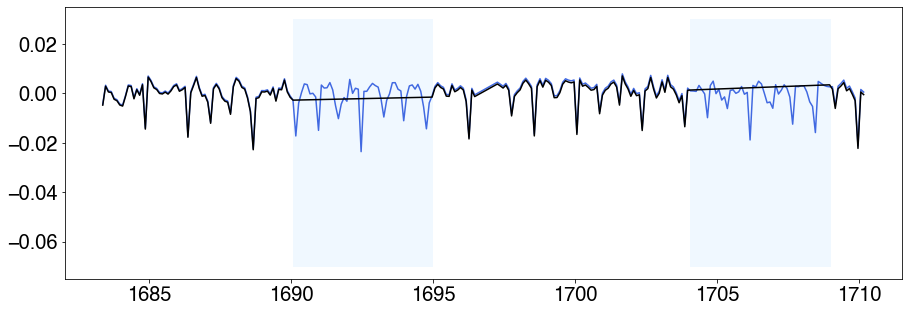

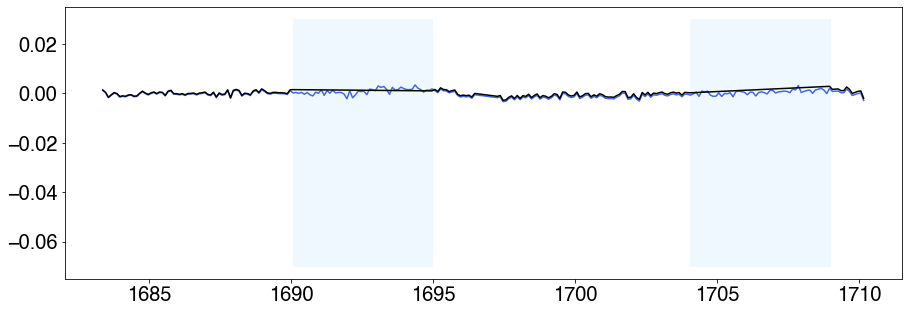

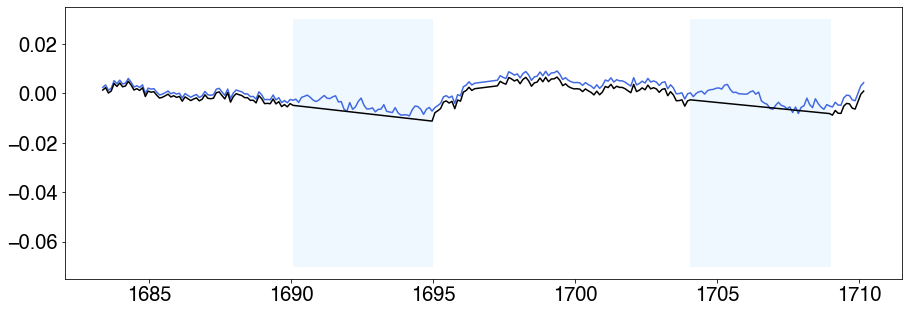

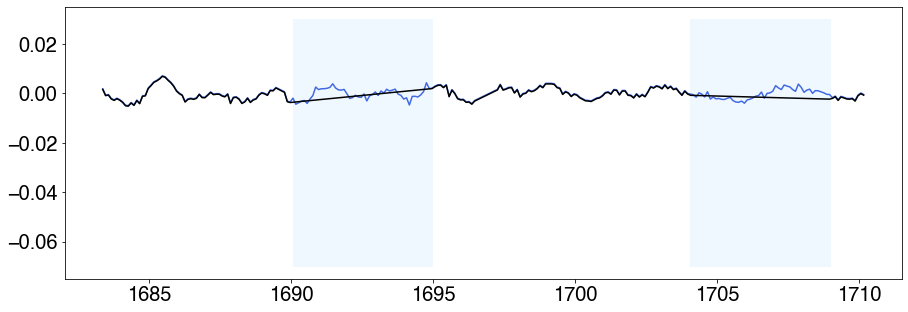

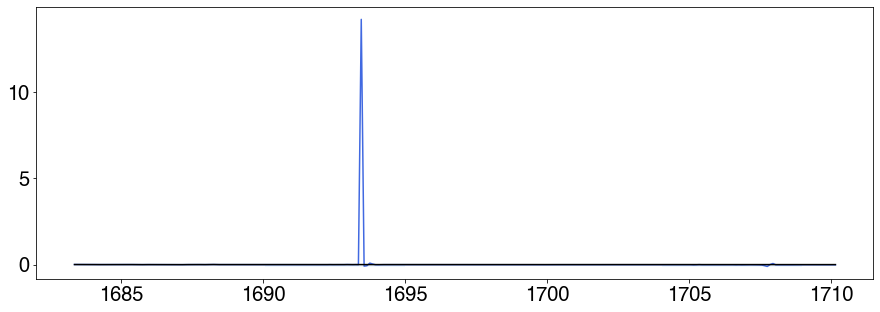

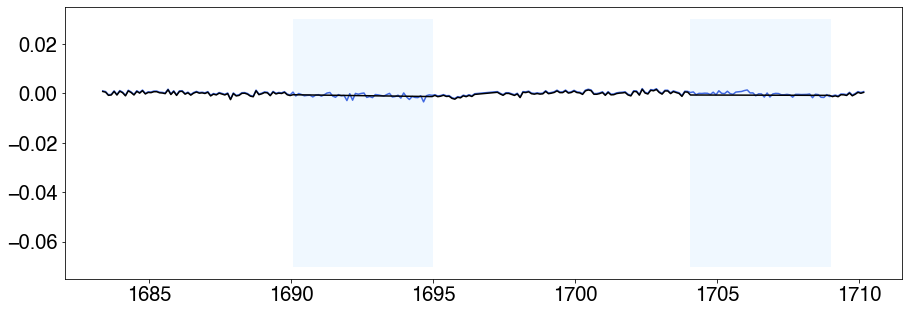

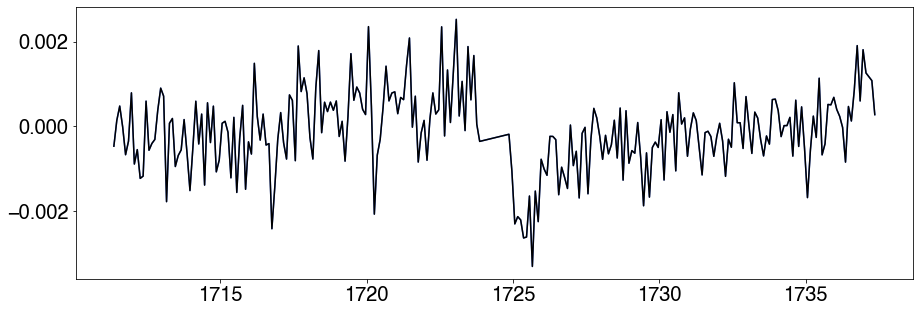

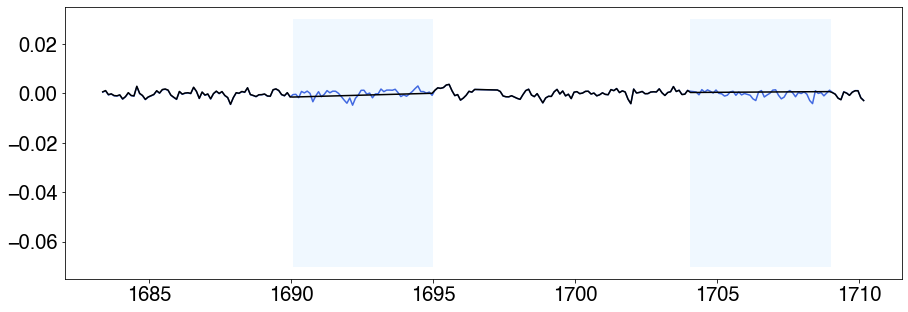

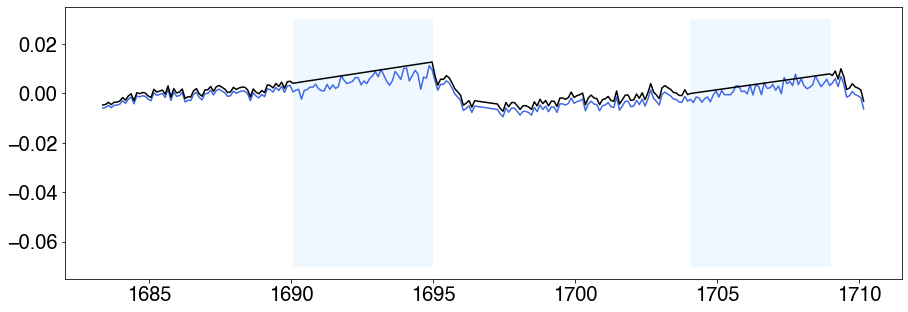

In [14]:
ls_two = []
pdm_two = []
exo_two = []

for each, tic in enumerate(tess_2m): 
    star = lk.search_targetpixelfile('TIC' + str(tic), mission = 'TESS').download();
    #pixelfile = search_targetpixelfile("KIC 8462852", quarter=16).download();
    
    lc = star.to_lightcurve(aperture_mask='all');

    time = lc.time
    flux_nan = (lc.flux[~np.isnan(lc.flux)])
    norm_flux = flux_nan/np.nanmedian(lc.flux)
   
    try: 
    #original 
        norm_flux_err = np.sqrt(norm_flux)
        resid = residuals(time, norm_flux, norm_flux_err)
        resid = resid[~np.isnan(resid)]
        time = time[~np.isnan(resid)]   
        
        f = interpolate.interp1d(time, resid)
        xnew = np.arange(time[0], time[-1], 0.1)
        flux = f(xnew) 
        flux_err = np.sqrt(flux)

        #cropping out section
        mask = (time <= 1695) & (time >= 1690)
        norm_flux_2 = norm_flux[~mask]
        time_masked = time[~mask]
    
        mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
        norm_flux_mask = norm_flux_2[~mask_2]
        time_mask = time_masked[~mask_2]

        #removing trends 
        norm_flux_err_mask = np.sqrt(norm_flux_mask)
        resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
        resid_mask = resid_mask[~np.isnan(resid_mask)]
        time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
        f = interpolate.interp1d(time_mask, resid_mask)
        xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
        flux_mask = f(xnew_mask) 
        flux_err_mask = np.sqrt(flux_mask)
    
        fig, axs = plt.subplots()
        fig.tight_layout(h_pad=6)
        plt.figure(figsize=(15,5))
        plt.plot(xnew, flux, 'royalblue')
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1690) & (xnew <= 1695), 
                 color = 'aliceblue') 
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1704) & (xnew <= 1709), 
                 color = 'aliceblue')

        plt.plot(xnew_mask, flux_mask, 'k')
        fig.savefig('tess_{0}_30m.jpg'.format(each))
        plt.close(fig)

        #exo acf
        ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
        exo_period = ex_1['peaks'][0]['period']
        exo_two.append(exo_period)

        
        #lomb-scargle 
        rotate_el = ss.RotationModel(xnew_mask, flux_mask, flux_err_mask)
        ls_period = rotate_el.ls_rotation()
        ls_two.append(ls_period)
       
        #pdm 
        period_grid = np.linspace(.1, 10, 1000)
        pdm_period, period_err = rotate_el.pdm_rotation(period_grid, pdm_nbins=10)    
        pdm_two.append(pdm_period)
        print('works!')
    
        
    except : 
        print('error')
        ls_two.append(0)
        pdm_two.append(0)
        exo_two.append(0)

with open('ls_two.data', 'wb') as filehandle:
    pickle.dump(ls_two, filehandle)
    
with open('pdm_two.data', 'wb') as filehandle:
    pickle.dump(pdm_two, filehandle)
    
with open('exo_two.data', 'wb') as filehandle:
    pickle.dump(exo_two, filehandle)  

In [15]:
diff_two = []
for each, per in enumerate(exo_two):
    tic = tess_2m[each]
    index = np.where(np.array(tics_short_periods) == tic)
    mcq_period = short_periods[index[0][0]]

    diff = np.abs(per - mcq_period)
    diff_two.append(diff)

diff_thirty = []
for each, per in enumerate(exo_thirty):
    tiz = tess_30m[each][3:]
    index = np.where(np.array(tics_short_periods) == np.int(tiz))
    mcq_period = short_periods[index[0][0]]

    diff = np.abs(per - mcq_period)
    diff_thirty.append(diff)

Text(0.5, 0, 'Calculated Period')

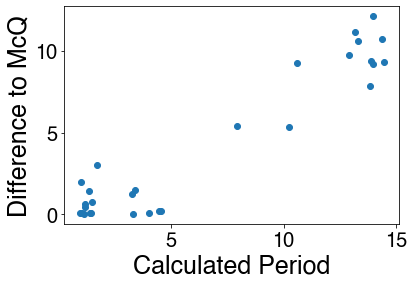

In [16]:
plt.scatter(exo_two, diff_two)
plt.ylabel('Difference to McQ')
plt.xlabel('Calculated Period')

plt.scatter(exo_thirty, diff_thirty)
plt.ylabel('Difference to McQ')
plt.xlabel('Calculated Period')

In [ ]:
for index, each in enumerate(tess_2m):
    for ind, every in enumerate(tess_30m):
        if int(every[3:]) == each: 
            indx = np.where(np.array(tics_short_periods) == each)
            mcq_period = short_periods[indx[0][0]]
            print(mcq_period, each, np.array(exo_two)[index], exo_thirty[ind], index, ind)

# testing aperture changes

In [23]:
star = lk.search_targetpixelfile('TIC' + str(tess_2m[0]), mission = 'TESS').download();    
lc = star.to_lightcurve(aperture_mask='threshold');

time = lc.time
flux_nan = (lc.flux[~np.isnan(lc.flux)])
norm_flux = flux_nan/np.nanmedian(lc.flux)
   
norm_flux_err = np.sqrt(norm_flux)
resid = residuals(time, norm_flux, norm_flux_err)
resid = resid[~np.isnan(resid)]
time = time[~np.isnan(resid)]   
        
f = interpolate.interp1d(time, resid)
xnew = np.arange(time[0], time[-1], 0.1)
flux = f(xnew) 
flux_err = np.sqrt(flux)

        #cropping out section
mask = (time <= 1695) & (time >= 1690)
norm_flux_2 = norm_flux[~mask]
time_masked = time[~mask]
    
mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
norm_flux_mask = norm_flux_2[~mask_2]
time_mask = time_masked[~mask_2]

        #removing trends 
norm_flux_err_mask = np.sqrt(norm_flux_mask)
resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
resid_mask = resid_mask[~np.isnan(resid_mask)]
time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
f = interpolate.interp1d(time_mask, resid_mask)
xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
flux_mask = f(xnew_mask) 
flux_err_mask = np.sqrt(flux_mask)
    
        #exo acf
ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period']
print(exo_period)

3.6499999999966803


In [33]:
ex_1

{'autocorr': (array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
          0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
          0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
          1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
          1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
          2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
          2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
          3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
          3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
          4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
          4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
          4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
          5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
          5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  

In [24]:
exo_two[0]

13.299999999987904

In [27]:
exo_two[0]-diff_two[0]

2.67

No eleanor postcard has been made for your target (yet). Using TessCut instead.




100%|██████████| 1197/1197 [00:21<00:00, 55.84it/s]


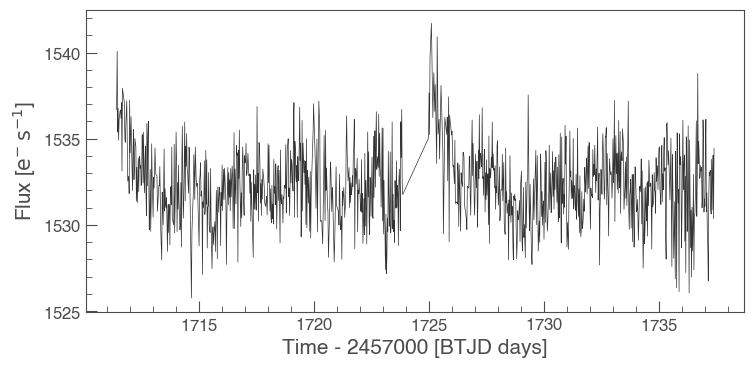

In [30]:
star3 = eleanor.Source(tic=tess_2m[0])
data3 = eleanor.TargetData(star3, do_psf=True, do_pca=True)

lk = data3.to_lightkurve()
lk.plot()

In [28]:
star.interact()

In [32]:
lc = star.to_lightcurve(aperture_mask='pipeline');

time = lc.time
flux_nan = (lc.flux[~np.isnan(lc.flux)])
norm_flux = flux_nan/np.nanmedian(lc.flux)
   
norm_flux_err = np.sqrt(norm_flux)
resid = residuals(time, norm_flux, norm_flux_err)
resid = resid[~np.isnan(resid)]
time = time[~np.isnan(resid)]   
        
f = interpolate.interp1d(time, resid)
xnew = np.arange(time[0], time[-1], 0.1)
flux = f(xnew) 
flux_err = np.sqrt(flux)

        #cropping out section
mask = (time <= 1695) & (time >= 1690)
norm_flux_2 = norm_flux[~mask]
time_masked = time[~mask]
    
mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
norm_flux_mask = norm_flux_2[~mask_2]
time_mask = time_masked[~mask_2]

        #removing trends 
norm_flux_err_mask = np.sqrt(norm_flux_mask)
resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
resid_mask = resid_mask[~np.isnan(resid_mask)]
time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
f = interpolate.interp1d(time_mask, resid_mask)
xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
flux_mask = f(xnew_mask) 
flux_err_mask = np.sqrt(flux_mask)
    
        #exo acf
ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period']
print(exo_period)

1.3499999999987722


In [21]:
exo_thresh = []

for each, tic in enumerate(tess_2m): 
    star = lk.search_targetpixelfile('TIC' + str(tic), mission = 'TESS').download();    
    lc = star.to_lightcurve(aperture_mask='threshold');

    time = lc.time
    flux_nan = (lc.flux[~np.isnan(lc.flux)])
    norm_flux = flux_nan/np.nanmedian(lc.flux)
   
    try: 
    #original 
        norm_flux_err = np.sqrt(norm_flux)
        resid = residuals(time, norm_flux, norm_flux_err)
        resid = resid[~np.isnan(resid)]
        time = time[~np.isnan(resid)]   
        
        f = interpolate.interp1d(time, resid)
        xnew = np.arange(time[0], time[-1], 0.1)
        flux = f(xnew) 
        flux_err = np.sqrt(flux)

        #cropping out section
        mask = (time <= 1695) & (time >= 1690)
        norm_flux_2 = norm_flux[~mask]
        time_masked = time[~mask]
    
        mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
        norm_flux_mask = norm_flux_2[~mask_2]
        time_mask = time_masked[~mask_2]

        #removing trends 
        norm_flux_err_mask = np.sqrt(norm_flux_mask)
        resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
        resid_mask = resid_mask[~np.isnan(resid_mask)]
        time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
        f = interpolate.interp1d(time_mask, resid_mask)
        xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
        flux_mask = f(xnew_mask) 
        flux_err_mask = np.sqrt(flux_mask)
    
        fig, axs = plt.subplots()
        fig.tight_layout(h_pad=6)
        plt.figure(figsize=(15,5))
        plt.plot(xnew, flux, 'royalblue')
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1690) & (xnew <= 1695), 
                 color = 'aliceblue') 
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1704) & (xnew <= 1709), 
                 color = 'aliceblue')

        plt.plot(xnew_mask, flux_mask, 'k')
        fig.savefig('tess_{0}_2m_thresh.jpg'.format(each))
        plt.close(fig)

        #exo acf
        ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
        exo_period = ex_1['peaks'][0]['period']
        exo_thresh.append(exo_period)
        
    except : 
        print('error')
        exo_thresh.append(0)

KeyboardInterrupt: 

In [ ]:
diff_thresh = []
for each, per in enumerate(exo_thresh):
    tic = tess_2m[each]
    index = np.where(np.array(tics_short_periods) == tic)
    mcq_period = short_periods[index[0][0]]

    diff = np.abs(per - mcq_period)
    diff_thresh.append(diff)

In [ ]:
plt.scatter(exo_thresh, diff_two)
plt.ylabel('Difference to McQ')
plt.xlabel('Calculated Period')

star3 = eleanor.Source(tic=tics_short_periods[3])
data3 = eleanor.TargetData(star3, do_psf=True, do_pca=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data3.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data3.aperture)
ax2.set_title('Aperture');

star3 = search_targetpixelfile('TIC 121457565').download(quality_bitmask='default');

star3.interact()

lk = data3.to_lightkurve()
lk.plot()